In [1]:
!pip3 install -U numpy==1.21.4
!pip3 install -U pandas
!pip3 install -U scikit-learn
!pip3 install -U keras
!pip3 install -U tensorflow==2.12.0
!pip3 install -U optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 46.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.10.1 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.21.4 which is incompatible.
ydata-profiling 4.1.2 requires scipy<1.10,>=1.4.1, but you have scipy 1.10.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
#importing all the necessary libraries
import os
import pandas as pd
import numpy as np
import cv2 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
from optuna.trial import TrialState
from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import TPESampler

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
#processing and resizing the images

labels = ['PNEUMONIA', 'NORMAL']
img_size = 100
def resizing_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

In [4]:
#preparing the paths for the training, testing and validation data 

train = resizing_data('../input/chest-xray-pneumonia/chest_xray/train')
test = resizing_data('../input/chest-xray-pneumonia/chest_xray/test')
val = resizing_data('../input/chest-xray-pneumonia/chest_xray/val')

In [5]:
#counting the number of normal and pneumonia diagnostics

pnenumonia = 0 
normal = 0 

for i, j in train:
    if j == 0:
        pnenumonia+=1
    else:
        normal+=1
        
print('Pneumonia:', pnenumonia)
print('Normal:', normal)
print('Total:', pnenumonia+normal)

Pneumonia: 3875
Normal: 1341
Total: 5216


PNEUMONIA


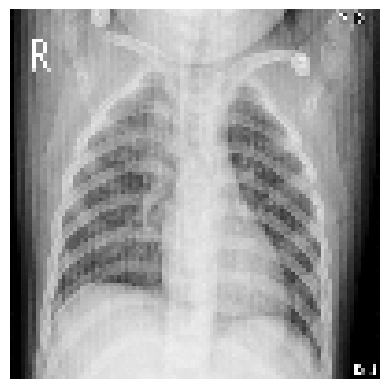

In [6]:
#visualizing the training images

plt.imshow(train[1][0], cmap='gray')
plt.axis('off')
print(labels[train[1][1]])

PNEUMONIA


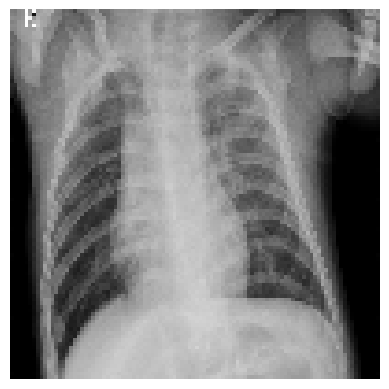

In [7]:
#visualizing the testing images

plt.imshow(test[1][0], cmap='gray')
plt.axis('off')
print(labels[test[1][1]])

PNEUMONIA


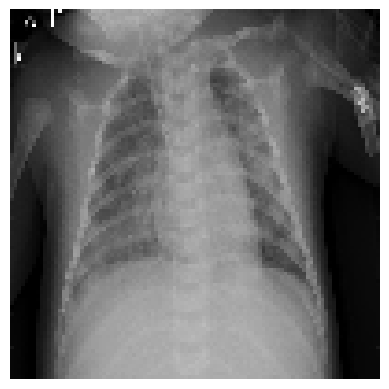

In [8]:
#visualizing the validation images

plt.imshow(val[1][0], cmap='gray')
plt.axis('off')
print(labels[val[1][1]])

In [9]:
X = []
y = []

for feature, label in train:
    X.append(feature)
    y.append(label)

for feature, label in test:
    X.append(feature)
    y.append(label)
    
for feature, label in val:
    X.append(feature)
    y.append(label)


# resize data for deep learning 
X = np.array(X).reshape(-1, img_size, img_size, 1)
y = np.array(y)

#incoprating the validation data into the training data because it does not contain enough examples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=32)

In [10]:
# good for balancing out disproportions in the dataset 
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=90, 
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True)  

datagen.fit(X_train)

In [11]:
def objective(trial):
    # Define the CNN model
    model = Sequential()

    model.add(Conv2D(256, (3, 3), input_shape=X_train.shape[1:], padding='same'))
    activation_1 = trial.suggest_categorical('activation_1', ["sigmoid", "relu", "linear", "tanh", "softmax", "elu", "selu"])
    model.add(Activation(activation_1))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(BatchNormalization(axis=1))

    model.add(Conv2D(64, (3, 3), padding='same'))
    activation_2 = trial.suggest_categorical('activation_2', ["sigmoid", "relu", "linear", "tanh", "softmax", "elu", "selu"])
    model.add(Activation(activation_2))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(BatchNormalization(axis=1))

    model.add(Conv2D(16, (3, 3), padding='same'))
    activation_3 = trial.suggest_categorical('activation_3', ["sigmoid", "relu", "linear", "tanh", "softmax", "elu", "selu"])
    model.add(Activation(activation_3))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(BatchNormalization(axis=1))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

    model.add(Dropout(trial.suggest_float('dropout', 0.1, 0.5)))
    model.add(Dense(64))
    activation_4 = trial.suggest_categorical('activation_4', ["sigmoid", "relu", "linear", "tanh", "softmax", "elu", "selu"])
    model.add(Activation(activation_4))

    model.add(Dropout(trial.suggest_float('dropout', 0.1, 0.5)))
    model.add(Dense(1))
    activation_5 = trial.suggest_categorical('activation_5', ["sigmoid", "relu", "linear", "tanh", "softmax", "elu", "selu"])
    model.add(Activation(activation_5))

    # Compile the model with the suggested optimizer and loss function
    optimizer = trial.suggest_categorical('optimizer', ["sgd","rmsprop", "adam", "adadelta", "adagrad", "adamax", "nadam", "ftrl"])
    loss = trial.suggest_categorical('loss', ["binary_crossentropy","mean_squared_error", "mean_absolute_error", "hinge"])
    epochs = trial.suggest_int("epochs", 10, 30, step=5)
    batch_size = trial.suggest_int("batch_size", 16, 256, step=16)
    early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    # Train the model with the dataset
    model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), callbacks=[early_stop], validation_data=(X_val, y_val), epochs=epochs)

    # Return the validation accuracy as the objective value for Optuna to maximize
    classes_x = (model.predict(X_test) > 0.5).astype("int32")
    score = accuracy_score(y_test,classes_x)  

    if trial.should_prune():
      raise optuna.exceptions.TrialPruned() 

    return score

# Run the Optuna optimization
study = optuna.create_study(sampler = TPESampler(),pruner = SuccessiveHalvingPruner(),direction='maximize')
study.optimize(objective, n_trials=3)

# Print the best hyperparameters and objective value
trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params)) 

[I 2023-05-26 09:27:15,835] A new study created in memory with name: no-name-b3c5e076-e53d-4014-a75e-d94ae1ac1ec3


Epoch 1/15
16/16 [==============================] - 265s 16s/step - loss: 1.4604 - accuracy: 0.2698 - val_loss: 1.4813 - val_accuracy: 0.2593
Epoch 2/15
16/16 [==============================] - 261s 16s/step - loss: 1.4604 - accuracy: 0.2698 - val_loss: 1.4813 - val_accuracy: 0.2593
Epoch 3/15
16/16 [==============================] - 262s 16s/step - loss: 1.4604 - accuracy: 0.2698 - val_loss: 1.4813 - val_accuracy: 0.2593
Epoch 4/15
37/37 [==============================] - 22s 593ms/step


[I 2023-05-26 09:46:28,441] Trial 0 finished with value: 0.28071672354948807 and parameters: {'activation_1': 'linear', 'activation_2': 'tanh', 'activation_3': 'tanh', 'dropout': 0.14451497957622927, 'activation_4': 'softmax', 'activation_5': 'softmax', 'optimizer': 'ftrl', 'loss': 'hinge', 'epochs': 15, 'batch_size': 240}. Best is trial 0 with value: 0.28071672354948807.


Epoch 1/30
24/24 [==============================] - 306s 13s/step - loss: 1.0167 - accuracy: 0.7214 - val_loss: 1.0010 - val_accuracy: 0.7407
Epoch 2/30
24/24 [==============================] - 331s 14s/step - loss: 1.0021 - accuracy: 0.7302 - val_loss: 1.0005 - val_accuracy: 0.7407
Epoch 3/30
24/24 [==============================] - 311s 13s/step - loss: 1.0013 - accuracy: 0.7302 - val_loss: 1.0002 - val_accuracy: 0.7407
Epoch 4/30
24/24 [==============================] - 337s 14s/step - loss: 1.0010 - accuracy: 0.7302 - val_loss: 1.0001 - val_accuracy: 0.7407
Epoch 5/30
24/24 [==============================] - 311s 13s/step - loss: 1.0008 - accuracy: 0.7302 - val_loss: 1.0001 - val_accuracy: 0.7407
Epoch 6/30
24/24 [==============================] - 333s 14s/step - loss: 1.0006 - accuracy: 0.7302 - val_loss: 1.0001 - val_accuracy: 0.7407
Epoch 7/30
24/24 [==============================] - 306s 13s/step - loss: 1.0006 - accuracy: 0.7302 - val_loss: 1.0000 - val_accuracy: 0.7407
Epoch 

[I 2023-05-26 12:37:36,653] Trial 1 finished with value: 0.7192832764505119 and parameters: {'activation_1': 'elu', 'activation_2': 'elu', 'activation_3': 'tanh', 'dropout': 0.40621977282200816, 'activation_4': 'relu', 'activation_5': 'sigmoid', 'optimizer': 'sgd', 'loss': 'hinge', 'epochs': 30, 'batch_size': 160}. Best is trial 1 with value: 0.7192832764505119.


Epoch 1/20
15/15 [==============================] - 351s 23s/step - loss: 0.5814 - accuracy: 0.7195 - val_loss: 0.5495 - val_accuracy: 0.7407
Epoch 2/20
15/15 [==============================] - 332s 22s/step - loss: 0.5397 - accuracy: 0.7302 - val_loss: 0.5305 - val_accuracy: 0.7407
Epoch 3/20
15/15 [==============================] - 316s 21s/step - loss: 0.5397 - accuracy: 0.7302 - val_loss: 0.5273 - val_accuracy: 0.7407
Epoch 4/20
15/15 [==============================] - 346s 23s/step - loss: 0.5397 - accuracy: 0.7302 - val_loss: 0.5264 - val_accuracy: 0.7407
Epoch 5/20
15/15 [==============================] - 311s 21s/step - loss: 0.5397 - accuracy: 0.7302 - val_loss: 0.5256 - val_accuracy: 0.7407
Epoch 6/20
15/15 [==============================] - 343s 23s/step - loss: 0.5397 - accuracy: 0.7302 - val_loss: 0.5246 - val_accuracy: 0.7407
Epoch 7/20
15/15 [==============================] - 311s 21s/step - loss: 0.5397 - accuracy: 0.7302 - val_loss: 0.5235 - val_accuracy: 0.7407
Epoch 

[I 2023-05-26 14:34:21,460] Trial 2 finished with value: 0.7192832764505119 and parameters: {'activation_1': 'elu', 'activation_2': 'elu', 'activation_3': 'softmax', 'dropout': 0.22561589759611556, 'activation_4': 'tanh', 'activation_5': 'elu', 'optimizer': 'nadam', 'loss': 'hinge', 'epochs': 20, 'batch_size': 256}. Best is trial 1 with value: 0.7192832764505119.


Accuracy: 0.7192832764505119
Best hyperparameters: {'activation_1': 'elu', 'activation_2': 'elu', 'activation_3': 'tanh', 'dropout': 0.40621977282200816, 'activation_4': 'relu', 'activation_5': 'sigmoid', 'optimizer': 'sgd', 'loss': 'hinge', 'epochs': 30, 'batch_size': 160}


In [12]:
model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X_train.shape[1:], padding='same'))
model.add(Activation('tanh'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('selu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('softmax'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dropout(0.3175418729059378))
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.3175418729059378))
model.add(Dense(1))
model.add(Activation('tanh'))

model.compile(loss='binary_crossentropy',optimizer='sgd',metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 100, 100, 256)     2560      
                                                                 
 activation_15 (Activation)  (None, 100, 100, 256)     0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 50, 50, 256)      0         
 2D)                                                             
                                                                 
 batch_normalization_9 (Batc  (None, 50, 50, 256)      200       
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (None, 50, 50, 64)        147520    
                                                                 
 activation_16 (Activation)  (None, 50, 50, 64)       

In [13]:
early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
model.fit(datagen.flow(X_train, y_train, batch_size=192), callbacks=[early_stop], validation_data=(X_val, y_val), epochs=25)

Epoch 1/25
20/20 [==============================] - 322s 16s/step - loss: 4.1295 - accuracy: 0.7254 - val_loss: 4.0003 - val_accuracy: 0.7407
Epoch 2/25
20/20 [==============================] - 291s 15s/step - loss: 4.1619 - accuracy: 0.7302 - val_loss: 4.0003 - val_accuracy: 0.7407
Epoch 3/25
20/20 [==============================] - 324s 16s/step - loss: 7.1354 - accuracy: 0.5306 - val_loss: 11.2945 - val_accuracy: 0.2593
Epoch 4/25
20/20 [==============================] - 295s 15s/step - loss: 10.6374 - accuracy: 0.2880 - val_loss: 1.1332 - val_accuracy: 0.2593
Epoch 5/25
20/20 [==============================] - 323s 16s/step - loss: 4.3538 - accuracy: 0.7088 - val_loss: 4.0003 - val_accuracy: 0.7407
Epoch 6/25
20/20 [==============================] - 296s 15s/step - loss: 4.1657 - accuracy: 0.7294 - val_loss: 4.0003 - val_accuracy: 0.7407
Epoch 7/25
20/20 [==============================] - 322s 16s/step - loss: 4.1558 - accuracy: 0.7299 - val_loss: 4.0003 - val_accuracy: 0.7407


In [14]:
model.evaluate(X_test, y_test)

37/37 [==============================] - 24s 652ms/step - loss: 1.1084 - accuracy: 0.2807


[1.1083890199661255, 0.2807167172431946]

In [15]:
predictions = model.predict(X_test)
percentage = abs (predictions.mean() * 100)
print('Percentage of chances of having pneumonia:', percentage)

37/37 [==============================] - 24s 654ms/step
Percentage of chances of having pneumonia: 76.13928318023682


In [16]:
model.save('pneumonia_model.h5')